# 1. Inference on Synthetic data

Author: [Marc Lelarge](https://www.di.ens.fr/~lelarge/)

Date: 04/05

In this notebook, we test our approach on synthetic data.

The problem can be described as follows: we are given a familly of ODEs $y'=h_\theta(y,t)$, where the function $h$ is parametrized by the parameter $\theta$ and a trajectory $z$, the problem is to find the best value of $\theta$ such that $z'\approx h_{\theta}(z,t)$. In order to find the value of $\theta$, we follow an optimization approach using backpropagation through an ODE solver based on the tool developed in [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366). Namely, for a distance function $D$ on $\mathbb{R}^d$, we define $L = D(y_\theta -z)$ where $y_\theta$ is the solution of the ODE $y'=h_{\theta}(y,t)$ and we minimize the loss $L$ with respect to $\theta$ with SGD.

Here, to test this approach, we choose a parameter $\theta$ and integrate the ODE to get the trajectory $z$. We show that based on $z$, we are able to retrieve the parameter $\theta$.

In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## a. the IHD Model 

We propose a simple version of the SIR Model at the start of the epidemics. In this case, all the population is susceptible.

The standard SIR model is given by the equations:
\begin{eqnarray}
\dot{S}(t) &=& -\beta S(t) I(t)\\
\dot{I}(t) &=& \beta S(t) I(t) - \gamma I(t) -\nu I(t)\\
\dot{R}(t) &=& \gamma I(t)\\
\dot{D}(t) &=& \nu I(t)
\end{eqnarray}
where $S(t)$, $I(t)$, $R(t)$ and $D(t)$ are, respectively, the fractions of susceptible, infectious, recovered and deceased individuals at time $t$. $\beta$ is the contagion rate, $\gamma$ is the recovery rate and $\nu$ is the death rate.

In the early stage of the epidemics, we make the approximation $S(t) \approx 1$ so that the second equation simplifies to $\dot{I}(t) = \beta I(t) - \gamma I(t) -\nu I(t)$.

We make two other modifications:
- the contagion rate will depend on time $\beta(t)$
- we add a sub-category of the population $H(t)$, the numbers of individuals in hospital at time $t$. We assume that all deceased individuals are first in a hospital.

We obtain the IHD model given by the equations:
\begin{eqnarray}
\dot{I}(t) &=& \beta(t) I(t) -\gamma I(t)-\nu I(t)\\
\dot{R}(t) &=& \gamma I(t)\\
\dot{H}(t) &=& \nu I(t) - \gamma H(t) - \lambda H(t)\\
\dot{D}(t) &=& \lambda H(t)
\end{eqnarray}
note that the recovered individuals can be ignored to compute $I(t),H(t)$ and $D(t)$.

In practice, we will prametrize the function $\beta(t)$ as follows:
$$\beta(t) = \beta_1 +\delta \sigma(t-\tau),$$
where $\sigma(.)$ is the sigmoid function.

The motivation for using this specific function is to understand the impact of the lock-down on the epidemics. We expect the contagious rate to decrease under lock-down so that $\tau$ should be interpreted as the time when social distancing is implemented resulting in a drop in the contagious rate.

In [2]:
from model_epidemio import ihd_fit

In [47]:
size = 101
t = torch.linspace(0., size-1, size)
true_init = torch.tensor([[0.01,0., 0.]])
name_parms = ['beta', 'delta','gamma','nu','lambda']
parms = torch.tensor([0.1,-0.04,0.05,0.015,0.02])
time = torch.tensor([30.])
ihd_synt = ihd_fit.IHD_model(parms,time)

$\beta_1=0.1, \delta = -0.04, \gamma = 0.05, \nu = 0.015, \lambda = 0.02$

$\tau = 30$

$I(0)=0.01, H(0)=0, D(0)=0$

In [4]:
y_synt = ihd_fit.predic_ode(ihd_synt, true_init,t)

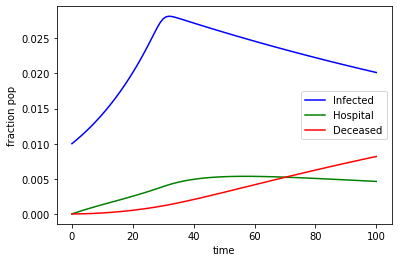

In [17]:
plt.plot(t,y_synt[:,0], 'b', label= 'Infected')
plt.plot(t,y_synt[:,1], 'g', label= 'Hospital')
plt.plot(t,y_synt[:,2], 'r', label= 'Deceased')
plt.ylabel('fraction pop')
plt.xlabel('time')
plt.legend();

Integration of the ODE: Infected = Blue, Hospital = green, Deaths = red

These trajectories are obtained by integrating the IHD model. To a 'non-specialist', these curves seem plausible: we observe the typical exponential growth at the start of the epidemics and when the R0 goes below one (around time 30), the number of Infected starts to decrease, as well as the number of individuals in hospital.

## b. Inference problem

Now given the trajectory depicted above, we try to recover the parameters of the model.

In [28]:
parms_fit = torch.tensor([0.15,-0.05,0.05,0.05,0.05])
time_fit = torch.tensor([50.])
ihd_time = ihd_fit.IHD_fit_time(parms_fit,time_fit)

In [29]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-3)
criterion = nn.MSELoss()

best_loss, best_parms = ihd_fit.trainig(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=600,data=y_synt)

10 9.737190703162923e-05 [tensor(0.1399), tensor(-0.0597), tensor(0.0603), tensor(0.0598), tensor(0.0354), tensor([39.9936])]
20 8.696584700373933e-05 [tensor(0.1398), tensor(-0.0593), tensor(0.0605), tensor(0.0594), tensor(0.0305), tensor([40.1213])]
30 7.744281174382195e-05 [tensor(0.1399), tensor(-0.0588), tensor(0.0606), tensor(0.0590), tensor(0.0258), tensor([40.3663])]
40 6.874083919683471e-05 [tensor(0.1400), tensor(-0.0582), tensor(0.0606), tensor(0.0584), tensor(0.0215), tensor([40.7014])]
50 6.11956711509265e-05 [tensor(0.1403), tensor(-0.0576), tensor(0.0605), tensor(0.0579), tensor(0.0177), tensor([41.0923])]
60 5.525864617084153e-05 [tensor(0.1405), tensor(-0.0569), tensor(0.0604), tensor(0.0573), tensor(0.0146), tensor([41.4944])]
70 5.1089285989291966e-05 [tensor(0.1407), tensor(-0.0561), tensor(0.0604), tensor(0.0567), tensor(0.0124), tensor([41.8583])]
80 4.835083018406294e-05 [tensor(0.1409), tensor(-0.0554), tensor(0.0604), tensor(0.0561), tensor(0.0111), tensor([42.

In [33]:
ihd_inf = ihd_fit.get_best_model(best_parms)

In [34]:
y_inf = ihd_fit.predic_ode(ihd_inf, true_init,t)

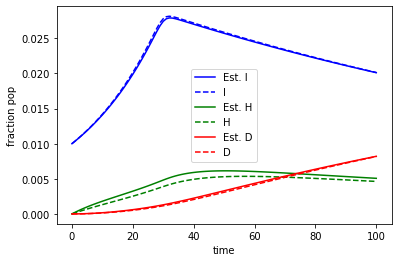

In [35]:
plt.plot(y_inf[:,0], 'b', label='Est. I')
plt.plot(y_synt[:,0], 'b--', label='I')
plt.plot(y_inf[:,1], 'g', label='Est. H')
plt.plot(y_synt[:,1], 'g--', label='H')
plt.plot(y_inf[:,2], 'r', label='Est. D')
plt.plot(y_synt[:,2], 'r--', label='D')
plt.ylabel('fraction pop')
plt.xlabel('time')
plt.legend();

Infected = Blue, Hospital = green, Deaths = red; dashed = true, plain = estimated.

We see that we have a good fit of the trajectories. Below, we look at the estimation of the parameters directly.

In [49]:
for i,p in enumerate(best_parms):
    try: 
        print(name_parms[i],',true: ', parms[i].item(), ',evaluated: ', p.data.item())
    except:
        print('time',',true: ', time.item(), ',evaluated: ', p.data.item())

beta ,true:  0.10000000149011612 ,evaluated:  0.13568738102912903
delta ,true:  -0.03999999910593033 ,evaluated:  -0.039264485239982605
gamma ,true:  0.05000000074505806 ,evaluated:  0.0784379169344902
nu ,true:  0.014999999664723873 ,evaluated:  0.022902600467205048
lambda ,true:  0.019999999552965164 ,evaluated:  0.01730191893875599
time ,true:  30.0 ,evaluated:  30.319229125976562


We see that the switching time is well estimated. The contagious and recovery rates $\gamma$ are overestimated.

## c. Inference problem with missing data

In practice, we will not have access to the whole trajectory. 


### c.1 missing hospital numbers

As an example, we consider here the case where the number of individuals in the hospital is not given. Hence, we have only access to the curves $I(t)$ and $D(t)$ but not $H(t)$.

This case fits nicely to our framework and we only need to modify the loss function in the optimization problem.

In [39]:
parms_fit = torch.tensor([0.15,-0.05,0.05,0.05,0.05])
time_fit = torch.tensor([50.])
ihd_time = ihd_fit.IHD_fit_time(parms_fit,time_fit)

In [42]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-3)
criterion = nn.MSELoss()

best_loss_partial, best_parms_partial = ihd_fit.trainig(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=600,data=(y_synt[:,0],y_synt[:,2]),all_data=False)

10 0.0002807293785735965 [tensor(0.1399), tensor(-0.0597), tensor(0.0603), tensor(0.0597), tensor(0.0360), tensor([40.0512])]
20 0.0002490270999260247 [tensor(0.1399), tensor(-0.0592), tensor(0.0604), tensor(0.0593), tensor(0.0316), tensor([40.2564])]
30 0.0002157771959900856 [tensor(0.1401), tensor(-0.0586), tensor(0.0604), tensor(0.0587), tensor(0.0270), tensor([40.6065])]
40 0.0001792468101484701 [tensor(0.1404), tensor(-0.0579), tensor(0.0603), tensor(0.0581), tensor(0.0225), tensor([41.0943])]
50 0.00013897537428420037 [tensor(0.1408), tensor(-0.0571), tensor(0.0600), tensor(0.0574), tensor(0.0179), tensor([41.7066])]
60 9.719401714392006e-05 [tensor(0.1413), tensor(-0.0561), tensor(0.0596), tensor(0.0566), tensor(0.0136), tensor([42.4038])]
70 6.0567286709556356e-05 [tensor(0.1419), tensor(-0.0550), tensor(0.0591), tensor(0.0558), tensor(0.0099), tensor([43.0911])]
80 3.730684329639189e-05 [tensor(0.1424), tensor(-0.0539), tensor(0.0586), tensor(0.0551), tensor(0.0072), tensor([4

In [43]:
ihd_inf = ihd_fit.get_best_model(best_parms_partial)
y_inf = ihd_fit.predic_ode(ihd_inf, true_init,t)

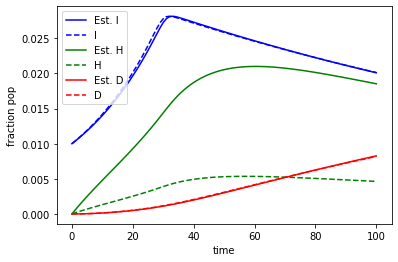

In [44]:
plt.plot(y_inf[:,0], 'b', label='Est. I')
plt.plot(y_synt[:,0], 'b--', label='I')
plt.plot(y_inf[:,1], 'g', label='Est. H')
plt.plot(y_synt[:,1], 'g--', label='H')
plt.plot(y_inf[:,2], 'r', label='Est. D')
plt.plot(y_synt[:,2], 'r--', label='D')
plt.ylabel('fraction pop')
plt.xlabel('time')
plt.legend();

We see that the number of individuals in hospital cannot be estimated although the number of infected and deceased individuals match very well.

In [50]:
for i,p in enumerate(best_parms_partial):
    try: 
        print(name_parms[i], ',true: ', parms[i].item(), ',evaluated: ', p.data.item())
    except:
        print('time', ',true: ', time.item(), ',evaluated: ', p.data.item())

beta ,true:  0.10000000149011612 ,evaluated:  0.1440642774105072
delta ,true:  -0.03999999910593033 ,evaluated:  -0.03891213983297348
gamma ,true:  0.05000000074505806 ,evaluated:  0.05708392709493637
nu ,true:  0.014999999664723873 ,evaluated:  0.05317461118102074
lambda ,true:  0.019999999552965164 ,evaluated:  0.005206960719078779
time ,true:  30.0 ,evaluated:  31.065773010253906


### c.2 missing infected

We now consider a case where the number of infected $I(t)$ is not available (for example, because the population is not tested). We only have acces to the number of individuals in hospital $H(t)$ and deceased individuals $D(t)$.

In [66]:
parms_fit = torch.tensor([0.15,-0.05,0.05,0.05,0.05])
time_fit = torch.tensor([50.])
ihd_time = ihd_fit.IHD_fit_time(parms_fit,time_fit)

In [67]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-3)
criterion = nn.MSELoss()

best_loss_hosp, best_parms_hosp = ihd_fit.trainig_hosp(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=500,data=(y_synt[:,1],y_synt[:,2]))

10 0.00010070865391753614 [tensor(0.1388), tensor(-0.0607), tensor(0.0613), tensor(0.0609), tensor(0.0359), tensor([38.7015])]
20 6.517423025798053e-05 [tensor(0.1379), tensor(-0.0612), tensor(0.0623), tensor(0.0614), tensor(0.0325), tensor([37.7925])]
30 4.61968666058965e-05 [tensor(0.1373), tensor(-0.0614), tensor(0.0630), tensor(0.0618), tensor(0.0296), tensor([37.1640])]
40 3.4617161873029545e-05 [tensor(0.1369), tensor(-0.0616), tensor(0.0636), tensor(0.0621), tensor(0.0272), tensor([36.7034])]
50 2.703325662878342e-05 [tensor(0.1365), tensor(-0.0617), tensor(0.0640), tensor(0.0622), tensor(0.0250), tensor([36.3555])]
60 2.1870018827030435e-05 [tensor(0.1362), tensor(-0.0618), tensor(0.0643), tensor(0.0624), tensor(0.0232), tensor([36.0887])]
70 1.828515451052226e-05 [tensor(0.1360), tensor(-0.0619), tensor(0.0646), tensor(0.0625), tensor(0.0215), tensor([35.8829])]
80 1.5778286979184486e-05 [tensor(0.1358), tensor(-0.0619), tensor(0.0648), tensor(0.0626), tensor(0.0201), tensor([

In [70]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-4)
criterion = nn.MSELoss()

best_loss_hosp, best_parms_hosp = ihd_fit.trainig_hosp(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=500,data=(y_synt[:,1],y_synt[:,2]))

10 2.090758471240406e-06 [tensor(0.1276), tensor(-0.0463), tensor(0.0746), tensor(0.0534), tensor(0.0156), tensor([70.2703])]
20 1.2782372778019635e-06 [tensor(0.1265), tensor(-0.0457), tensor(0.0760), tensor(0.0511), tensor(0.0164), tensor([79.7437])]
30 1.0145453188670217e-06 [tensor(0.1260), tensor(-0.0455), tensor(0.0768), tensor(0.0493), tensor(0.0169), tensor([83.8687])]
40 8.72749865266087e-07 [tensor(0.1256), tensor(-0.0454), tensor(0.0775), tensor(0.0478), tensor(0.0172), tensor([85.9186])]
50 7.771027412672993e-07 [tensor(0.1254), tensor(-0.0453), tensor(0.0780), tensor(0.0465), tensor(0.0175), tensor([86.9527])]
60 7.056780759739922e-07 [tensor(0.1252), tensor(-0.0453), tensor(0.0784), tensor(0.0454), tensor(0.0177), tensor([87.3938])]
70 6.494386752819992e-07 [tensor(0.1250), tensor(-0.0453), tensor(0.0788), tensor(0.0444), tensor(0.0179), tensor([87.4402])]
80 6.03648572905513e-07 [tensor(0.1248), tensor(-0.0453), tensor(0.0791), tensor(0.0435), tensor(0.0181), tensor([87.

In [74]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-4)
criterion = nn.MSELoss()

best_loss_hosp, best_parms_hosp = ihd_fit.trainig_hosp(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=500,data=(y_synt[:,1],y_synt[:,2]))

10 4.706962286604721e-08 [tensor(0.1248), tensor(-0.0244), tensor(0.0793), tensor(0.0245), tensor(0.0198), tensor([39.6252])]
20 4.56961330996819e-08 [tensor(0.1248), tensor(-0.0246), tensor(0.0793), tensor(0.0244), tensor(0.0197), tensor([39.6318])]
30 4.4367716611759533e-08 [tensor(0.1248), tensor(-0.0248), tensor(0.0793), tensor(0.0243), tensor(0.0197), tensor([39.6116])]
40 4.305403322746315e-08 [tensor(0.1248), tensor(-0.0250), tensor(0.0792), tensor(0.0242), tensor(0.0197), tensor([39.5729])]
50 4.174907886067558e-08 [tensor(0.1249), tensor(-0.0252), tensor(0.0792), tensor(0.0241), tensor(0.0197), tensor([39.5188])]
60 4.0451105576266855e-08 [tensor(0.1249), tensor(-0.0254), tensor(0.0792), tensor(0.0240), tensor(0.0197), tensor([39.4519])]
70 3.915929269737717e-08 [tensor(0.1249), tensor(-0.0256), tensor(0.0791), tensor(0.0239), tensor(0.0197), tensor([39.3738])]
80 3.787417313105834e-08 [tensor(0.1249), tensor(-0.0259), tensor(0.0791), tensor(0.0238), tensor(0.0198), tensor([39

In [75]:
ihd_inf = ihd_fit.get_best_model(best_parms_hosp)
y_inf = ihd_fit.predic_ode(ihd_inf, true_init,t)

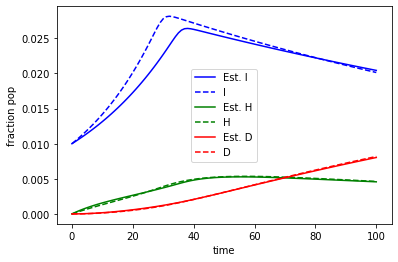

In [76]:
plt.plot(y_inf[:,0], 'b', label='Est. I')
plt.plot(y_synt[:,0], 'b--', label='I')
plt.plot(y_inf[:,1], 'g', label='Est. H')
plt.plot(y_synt[:,1], 'g--', label='H')
plt.plot(y_inf[:,2], 'r', label='Est. D')
plt.plot(y_synt[:,2], 'r--', label='D')
plt.ylabel('fraction pop')
plt.xlabel('time')
plt.legend();

We see that we obtain much better results here. Although we do not observe the curve of infected individuals, we are able to get a rough estimate of it.

In [77]:
for i,p in enumerate(best_parms_hosp):
    try: 
        print(name_parms[i], ',true: ', parms[i].item(), ',evaluated: ', p.data.item())
    except:
        print('time', ',true: ', time.item(), ',evaluated: ', p.data.item())

beta ,true:  0.10000000149011612 ,evaluated:  0.1260107010602951
delta ,true:  -0.03999999910593033 ,evaluated:  -0.03155003860592842
gamma ,true:  0.05000000074505806 ,evaluated:  0.07776334881782532
nu ,true:  0.014999999664723873 ,evaluated:  0.020897185429930687
lambda ,true:  0.019999999552965164 ,evaluated:  0.019811244681477547
time ,true:  30.0 ,evaluated:  35.96559143066406
